In [8]:
# 📦 Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Display plots inline
%matplotlib inline


In [9]:
# 🔽 Upload the CSV file
from google.colab import files
uploaded = files.upload()  # Upload 'netflix_titles.csv'


In [10]:
# 📄 Load dataset into DataFrame
df = pd.read_csv("netflix_titles.csv")

# 👀 Show first 5 rows
df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [12]:
# Check missing values again
print("Missing values:\n", df.isnull().sum())

# Drop rows with missing title or description
df.dropna(subset=["title", "description"], inplace=True)

# Clean 'country' safely
df['country'] = df['country'].fillna("Unknown")

# Strip extra spaces and convert 'date_added' to datetime
df['date_added'] = df['date_added'].str.strip()  # removes leading/trailing spaces
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')  # safely parse dates

# Create 'year_added' column
df['year_added'] = df['date_added'].dt.year

# Preview cleaned data
df[['title', 'country', 'date_added', 'year_added']].head()



Missing values:
 show_id            0
type               0
title              0
director        2634
cast             825
country            0
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


,title,country,date_added,year_added
0,Dick Johnson Is Dead,United States,2021-09-25,2021.0
1,Blood & Water,South Africa,2021-09-24,2021.0
2,Ganglands,Unknown,2021-09-24,2021.0
3,Jailbirds New Orleans,Unknown,2021-09-24,2021.0
4,Kota Factory,India,2021-09-24,2021.0


/tmp/ipython-input-13-3969595200.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df, palette='Set2')


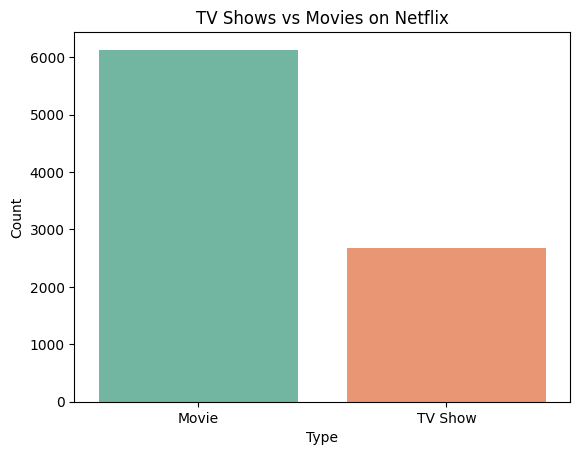

In [13]:
# 📺 Distribution of TV Shows vs Movies
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='type', data=df, palette='Set2')
plt.title("TV Shows vs Movies on Netflix")
plt.xlabel("Type")
plt.ylabel("Count")
plt.show()


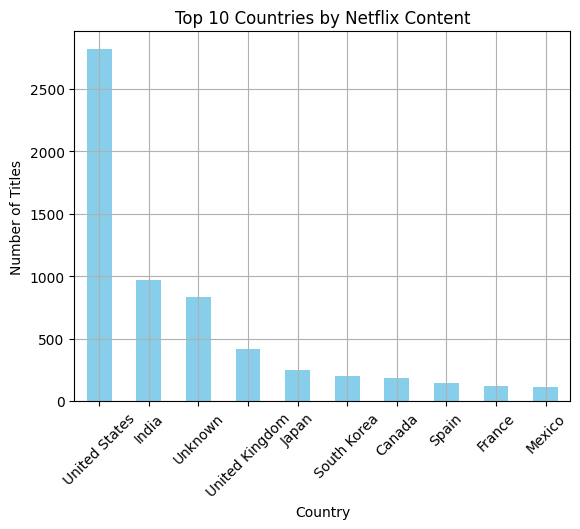

In [14]:
# 🌍 Top 10 countries producing the most Netflix content
top_countries = df['country'].value_counts().head(10)

top_countries.plot(kind='bar', color='skyblue')
plt.title("Top 10 Countries by Netflix Content")
plt.xlabel("Country")
plt.ylabel("Number of Titles")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


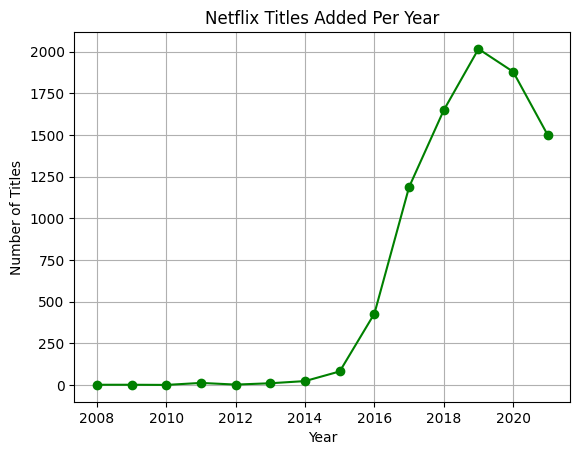

In [15]:
# 📅 Number of titles added to Netflix per year
yearly_content = df['year_added'].value_counts().sort_index()

yearly_content.plot(kind='line', marker='o', color='green')
plt.title("Netflix Titles Added Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Titles")
plt.grid(True)
plt.show()


/tmp/ipython-input-16-1147312646.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Genre', data=genres_df, palette='magma')


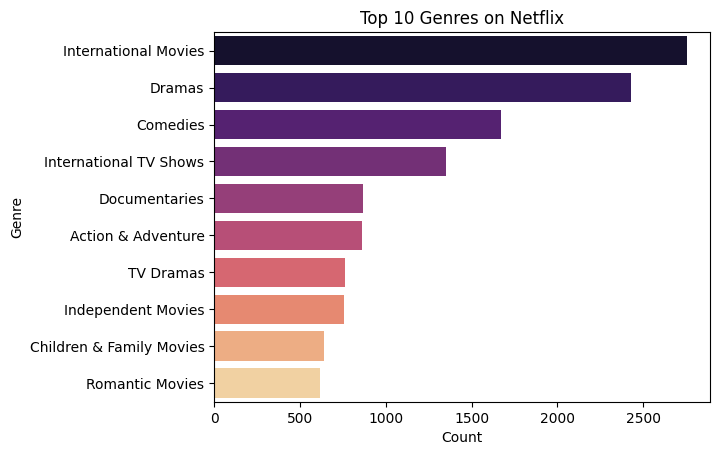

In [16]:
# 🎭 Extract and count genres from 'listed_in' column
from collections import Counter

genre_list = []
df['listed_in'].dropna().apply(lambda x: genre_list.extend(x.split(', ')))

# Count top 10 genres
top_genres = Counter(genre_list).most_common(10)

# Convert to DataFrame
genres_df = pd.DataFrame(top_genres, columns=['Genre', 'Count'])

# Plot
sns.barplot(x='Count', y='Genre', data=genres_df, palette='magma')
plt.title("Top 10 Genres on Netflix")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()


In [17]:
# ✏️ TF-IDF on 'description' column
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF Vectorizer (removes stopwords automatically)
tfidf = TfidfVectorizer(stop_words='english')

# Fit & transform descriptions
tfidf_matrix = tfidf.fit_transform(df['description'])

# Calculate cosine similarity between all items
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [18]:
# 🔢 Map titles to their DataFrame index
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

# 🎯 Recommend function
def recommend(title, cosine_sim=cosine_sim):
    if title not in indices:
        return "❌ Title not found in dataset."
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    show_indices = [i[0] for i in sim_scores]
    return df['title'].iloc[show_indices]


In [19]:
# 👀 Test it out — replace with a title from your dataset
recommend("Sherlock Holmes")


,title
8076,Spy Kids 3: Game Over
3836,In Family I Trust
4997,Borderliner
8032,Skiptrace
7494,Monster High: Fright On!


In [20]:
recommend("Spy Kids 3: Game Over")


,title
4143,Sparta
5454,Love.com
4809,Kiss Me First
8074,Spy Kids
4359,Spy Kids: Mission Critical
